# Gradient sanity checks and tests 
Checks:
- Gradients produced by 
    - EFGPND with stochastic trace
    - EFGPND without stochastic trace
    - Vanilla GP

- hyperparameter learning 


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/')
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/Graveyard/')
from efgpnd import efgpnd_gradient_batched
from vanilla_gp_sampling import sample_gp_fast, sample_gp_matern
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
import math
from utils.gradient_tests import compute_gradients_truncated, compute_gradients_vanilla
import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# Boring GP sampler

In [2]:


# --- Parameters ---
n = 200  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale =0.23
true_variance = 2
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 50
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2



# --- Generate Samples ---
print(f"Generating {1} sample for n={n} points in {d} dimensions...")
start_time = time.time()

# Sample using the optimized function
y = sample_gp_fast(
    x,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
).flatten().to(dtype=dtype)

end_time = time.time()
print(f"Generated sample of size {y.shape[0]}.")
print(f"Time taken: {end_time - start_time:.4f} seconds")


Using device: cpu
Generating 1 sample for n=200 points in 2 dimensions...
Generated sample of size 200.
Time taken: 0.0028 seconds


In [3]:
# save (x,y) to a torch file
# torch.save((x,y), f'gp_samples_{n}_{true_length_scale}_{true_variance}_{true_noise_variance}.pt')
# 

In [4]:
# load (x,y) from a torch file
# x, y = torch.load(f'gp_samples_{100_000}_{0.2}_{2}_{0.2}.pt')

In [5]:
EPSILON = 1e-4
sigmasq = torch.tensor(0.1, dtype=torch.float64)
kernel = SquaredExponential(dimension=d, lengthscale=torch.tensor([0.13]), variance=1)
init_kernel = kernel
# kernel = SquaredExponential(dimension=1, lengthscale=torch.tensor([0.5*1e-2]), variance=torch.tensor(1.0))



$$(F \beta)_i  = \sum_{k=1}^M \exp(2\pi i h \langle j_k, x_ i\rangle)\beta_k$$
is a discrete fourier transform, but $\langle j_k, x_i\rangle$ are not uniformly spaced 


$$F\beta = \mathcal{F}(\beta) \in \mathbb C ^N,$$
with spacing given by 
$2\pi h (x)$

$$\frac{\partial \mathcal L}{\partial \theta} = \frac{1}{2M} \sum_{k=1}^M z_k^T((K + \sigma^2I)^{-1} \frac{\partial (K + \sigma^2 I)}{\partial \theta}) z_k - \frac{1}{2}y^T (K +\sigma^2 I)^{-1}\frac{\partial (K + \sigma^2 I)}{\partial \theta} (K+\sigma^2I)^{-1}y =I - II $$

In [6]:
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  
# set seed
torch.manual_seed(42)
grad = efgpnd_gradient_batched(x.to(dtype=torch.float32), y.to(dtype=torch.float32), sigmasq, kernel, EPSILON, trace_samples=10, x0=x0, x1=x1)
print(grad)



tensor([-236.5699,  -12.1760, -251.1521])


# direct inversion using the fourier approximation 
- arbitrarily close to autograd on the unapproximated log likelihood

In [7]:

# Time the gradient computation
start_time = time.time()
true_grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)
print(true_grad)
end_time = time.time()
print(f"Time taken for gradient computation: {end_time - start_time:.2f} seconds")


tensor([-292.2492,  -12.2098, -251.1959], dtype=torch.float64)
Time taken for gradient computation: 0.11 seconds


# auto diff, full kernel, no approximations

In [8]:

grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
print(grad)


tensor([-292.1944,  -12.2100, -251.1848], dtype=torch.float64)


In [9]:
print(f'2d Check of gradients')
# x2d = torch.randn(100,2).to(dtype=torch.float64)
# y2d = torch.randn(100,).to(dtype=torch.float64)
torch.allclose(compute_gradients_vanilla(x, y, torch.tensor(0.1, dtype=torch.float64), kernel),compute_gradients_truncated(x, y, torch.tensor(0.1, dtype=torch.float64), kernel, 1e-5))
print(f'{d}-dimensional Check of gradients passed')

2d Check of gradients
2-dimensional Check of gradients passed


# hyper learning

In [10]:
kernel = init_kernel.model_copy()


In [11]:
lr = 0.001

In [12]:
# perform boring SGD using efgp1d_gradient and track hyperparameters
epsilon_values = [1e-4]
# trace_samples_values = [1,10, 50]
# trace_samples_values  = [5,10,25]
trace_samples_values = [10]
# precomp = precompute_efgp1d_setup(x, kernel, eps=EPSILON)
min_lengthscale = 0.5*1e-2
results = []
max_iters = 50
# set seed
torch.manual_seed(42)
print(f'init_kernel: {init_kernel}')
for epsilon in epsilon_values:
    for trace_samples in trace_samples_values:
        # time the training
        start_time = time.time()
        kernel = init_kernel.model_copy()
        sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
        log_marginals = []
        tracked_lengthscales = []
        tracked_variances = []
        tracked_noises = []

        for iter in range(max_iters):  # Perform 20 iterations of SGD
            # Track hyperparameters
            tracked_lengthscales.append(kernel.lengthscale)
            tracked_variances.append(kernel.variance)
            tracked_noises.append(sigmasq)
            # grad = efgp1d_gradient(x, y, sigmasq, kernel, epsilon, trace_samples=trace_samples)
            if iter<40:
                grad = efgpnd_gradient_batched(x, y, sigmasq, kernel, epsilon*100, trace_samples=1, x0=x0, x1=x1)
            else:
                grad = efgpnd_gradient_batched(x, y, sigmasq, kernel, epsilon/100, trace_samples=trace_samples, x0=x0, x1=x1)

            # grad = efgp1d_gradient_batched(x, y, sigmasq, kernel, EPSILON, trace_samples, precomp)
            # just clamping this for now
            kernel.lengthscale = max((torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item(),min_lengthscale)
            if iter < 3 and kernel.lengthscale < 0.05:
                lr = lr * 0.5  # Reduce learning rate by factor of 10
                print(f"Reduced learning rate to {lr} at iteration {iter} due to small lengthscale")
                kernel = init_kernel.model_copy()
            else:
                test_variance = max((torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item(),torch.tensor(1e-5))
                kernel.variance = max((torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item(),torch.tensor(1e-5))
                lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
                sigmasq = max((torch.exp(lognoise)), torch.tensor(1e-5))
            # print(f"Iteration {iter}: lengthscale = {kernel.lengthscale}, variance = {kernel.variance}, noise = {sigmasq}")
            if iter % 10 == 0:
                print(f'iter: {iter}')
                print(f'grad: ', grad)
                print(f'lengthscale: {kernel.lengthscale}')
                print(f'variance: {kernel.variance}')
                print(f'noise: {sigmasq}')
            # sigmasq = sigmasq - 0.0001 * grad[2]



            # beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=epsilon, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
            # log_marginals.append(kernel.log_marginal(x, y, sigmasq))
            # if iter % 10 == 0:
            #     print(f"Epsilon {epsilon}, Trace samples {trace_samples}, Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale}, variance = {kernel.variance}, noise = {sigmasq.item()}")

            # if torch.norm(grad) < 1e-5:
            #     print(f"Gradient is small at iteration {iter}. Stopping early.")
            #     break
        # Store results for this epsilon and trace_samples value
        results.append({
            'epsilon': epsilon,
            'trace_samples': trace_samples,
            'log_marginals': log_marginals,
            'tracked_lengthscales': tracked_lengthscales,
            'tracked_variances': tracked_variances,
            'tracked_noises': tracked_noises,
            'iters': iter
        })
        end_time = time.time()
        print(f"Training time for epsilon {epsilon}, trace_samples {trace_samples}: {end_time - start_time:.2f} seconds")


init_kernel: dimension=2 lengthscale=0.12999999523162842 variance=1.0 hypers=['lengthscale', 'variance'] num_hypers=3
iter: 0
grad:  tensor([-266.0839,  -19.0146, -184.0215], dtype=torch.float64)
lengthscale: 0.13457549136520094
variance: 1.0191965618010945
noise: 0.10185725125937127
iter: 10
grad:  tensor([-101.9326,   -9.8206, -160.7140], dtype=torch.float64)
lengthscale: 0.18043602334792666
variance: 1.0889286440053458
noise: 0.13605634963013735
iter: 20
grad:  tensor([-19.1712,  -6.8053, -85.5824], dtype=torch.float64)
lengthscale: 0.20514977620322972
variance: 1.1485427837394895
noise: 0.16849189935297068
iter: 30
grad:  tensor([-112.4794,   -0.6427,  -63.8174], dtype=torch.float64)
lengthscale: 0.21767097557778203
variance: 1.1981971737374306
noise: 0.1914635696193685
iter: 40
grad:  tensor([-19.9117,  -2.3540, -30.6350], dtype=torch.float64)
lengthscale: 0.22291567482806116
variance: 1.2473229305700173
noise: 0.2048969565710492
Training time for epsilon 0.0001, trace_samples 10:

In [13]:
# perform sgd on the vanilla kernel 
# time it 
start = time.time()
kernel = init_kernel.model_copy()
sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
log_marginals = []
tracked_lengthscales_vanilla = []
tracked_variances_vanilla = []
tracked_noises_vanilla = []
for iter in range(max_iters):  # Perform 20 iterations of SGD
        # Track hyperparameters
    tracked_lengthscales_vanilla.append(kernel.lengthscale)
    tracked_variances_vanilla.append(kernel.variance)
    tracked_noises_vanilla.append(sigmasq.item())
    grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
    # kernel.lengthscale = kernel.lengthscale - lr * grad[0]
    kernel.lengthscale = (torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item()
    kernel.variance = (torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item()
    lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
    sigmasq = (torch.exp(lognoise))
end = time.time()
print("Time taken for vanilla SGD: ", end-start)


epsilon_values = [.1,1e-2,1e-4]  # adjust or extend this list as needed
results_exacttrace = []  # Will store the results for each epsilon value.
max_iters = 50
# Loop over each epsilon value
for epsilon in epsilon_values:
    # Re-initialize kernel, learning rate, and other parameters for each run.
    kernel = init_kernel.model_copy()
    sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance

    # Ensure 'sigmasq' is defined. If not, set it to an initial value, e.g.:

    # Reset tracking lists for each epsilon run.
    log_marginals = []
    tracked_lengthscales = []
    tracked_variances = []
    tracked_noises = []
    
    # Run SGD for a fixed number of iterations (here 20 iterations)
    for iter in range(max_iters):
        # Compute gradients using the current epsilon value.
        # Track the updated hyperparameters.
        tracked_lengthscales.append(kernel.lengthscale)
        tracked_variances.append(kernel.variance)
        tracked_noises.append(sigmasq.item())
        grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON=epsilon)
        
        # Update kernel hyperparameters according to the gradients.
        # kernel.lengthscale = kernel.lengthscale - lr * grad[0]
        kernel.lengthscale = (torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item()
        kernel.variance = (torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item()
        lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
        sigmasq = (torch.exp(lognoise))
        # Optionally update noise if needed:
        # sigmasq = sigmasq - 0.0001 * grad[2]
        

        
        # Run the model prediction or log marginal likelihood evaluation.
        # beta, xis, ytrg = efgp1d(
        #     x_input, y_input,
        #     sigmasq=sigmasq,
        #     kernel=kernel,
        #     eps=epsilon,
        #     x_new=x,
        #     opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True}
        # )
        
        # # Compute and store the log marginal likelihood.
        # log_marginals.append(kernel.log_marginal(x, y, sigmasq))
        
        # Optionally, print intermediate diagnostics every 10 iterations.
        # if iter % 10 == 0:
        #     print(f"Epsilon {epsilon}, Iteration {iter}: log marginal = {log_marginals[-1]}, "
        #           f"grad = {grad}, lengthscale = {kernel.lengthscale}, "
        #           f"variance = {kernel.variance}, noise = {sigmasq.item()}")
        # break if grad is small
        if torch.norm(grad) < 1e-5:
            print(f"Gradient is small at iteration {iter}. Stopping early.")
            break
    
    # Save the results for this epsilon value into the results list.
    results_exacttrace.append({
        'epsilon': epsilon,
        'log_marginals': log_marginals,
        'tracked_lengthscales': tracked_lengthscales,
        'tracked_variances': tracked_variances,
        'tracked_noises': tracked_noises,
        'iters': iter
    })

# After looping over all epsilon values, 'results_exacttrace' contains the detailed trace for each run.


Time taken for vanilla SGD:  0.07331705093383789


# making a loss landscape

In [14]:
# calculate log marginal over a grid of lengthscales and variances
# Create grid centered around true values, ensuring init values are included
lengthscale_min = max(0.00001, min(init_kernel.lengthscale+0.01, true_length_scale - 0.1))
lengthscale_max = max(init_kernel.lengthscale+0.01, true_length_scale + 0.1)

variance_min = max(0.001, min(init_kernel.variance, true_variance - 2))
variance_max = max(init_kernel.variance, true_variance + 2)

lengthscales = torch.linspace(lengthscale_min, lengthscale_max, 50)
variances = torch.linspace(variance_min, variance_max, 50)
log_marginals_grid = torch.zeros((len(lengthscales), len(variances)))

# Calculate log marginal likelihood for each grid point
for i, lengthscale in enumerate(lengthscales):
    for j, variance in enumerate(variances):
        kernel = SquaredExponential(dimension=d, lengthscale=lengthscale.item(), variance=variance.item())
        log_marginals_grid[i, j] = kernel.log_marginal(x, y, sigmasq)



/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_11255/2016973872.py:53: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_11255/2016973872.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[.01, 0, 0.75, 1])


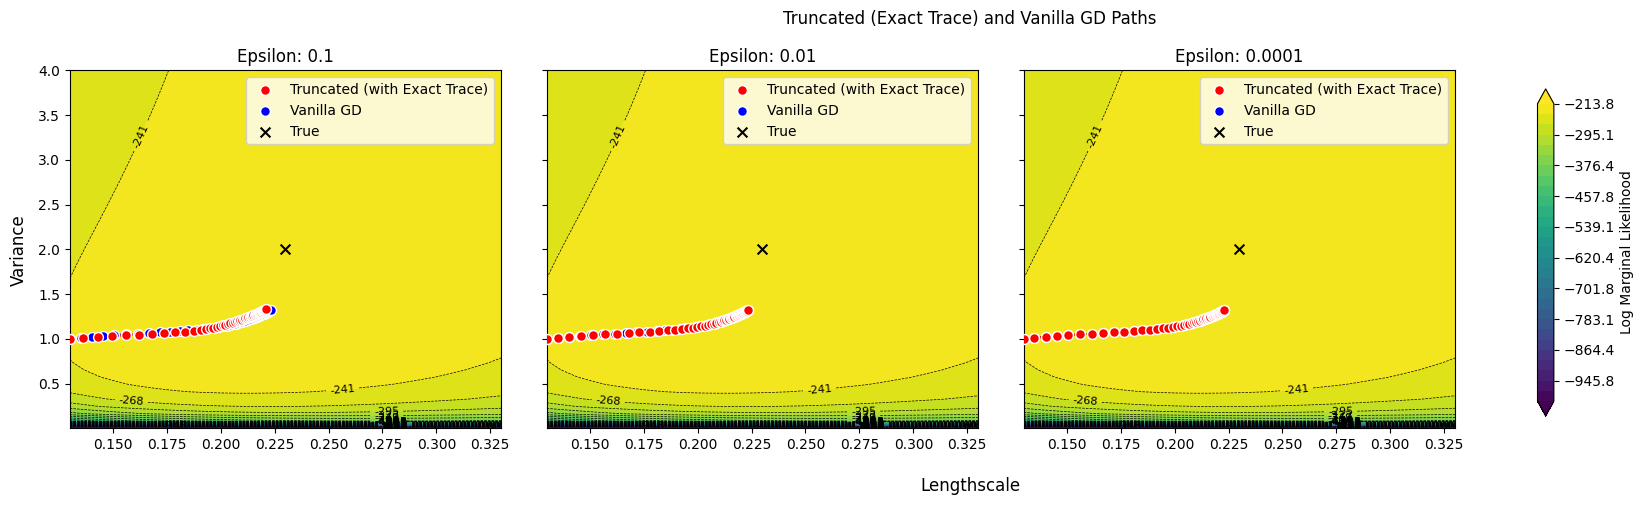

In [15]:

# For numerical stability, clip extremely low log marginal values.
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())
log_marginal_clipped = log_marginals_grid

# Set up detailed filled contour levels and slightly fewer levels for the line overlay.
fill_levels = np.linspace(-1000, log_marginals_grid.max(), 30)
line_levels = np.linspace(-1000, log_marginals_grid.max(), 30)

# Number of epsilon runs you have in results_exacttrace.
n_plots = len(results_exacttrace)

# Choose a layout: here we use 2 rows and as many columns as needed.
n_rows = 1
n_cols = int(np.ceil(n_plots / n_rows))

# Convert vanilla SGD tracking lists to arrays.
tracked_lengthscales_vanilla_arr = np.array(tracked_lengthscales_vanilla)
tracked_variances_vanilla_arr  = np.array(tracked_variances_vanilla)

# Create a grid of subplots for visualization.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to a 1D list for easy iteration

# Iterate over each subplot (each corresponding to a different epsilon value)
for i, ax in enumerate(axes):
    if i < n_plots:
        # Retrieve the current epsilon run's results.
        res = results_exacttrace[i]
        tracked_lengthscales_path = np.array(res.get('tracked_lengthscales', []))
        tracked_variances_path   = np.array(res.get('tracked_variances', []))
        
        # Plot the filled contours of log marginal likelihood.
        cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T,
                         levels=fill_levels, cmap='viridis', extend='both')
        # Overlay contour lines.
        cs = ax.contour(lengthscales, variances, log_marginal_clipped.T,
                        levels=line_levels, colors='k', linewidths=0.5)
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')
        

        
        # Plot the results_exacttrace SGD path for the current epsilon:
        ax.scatter(tracked_lengthscales_path, tracked_variances_path,
                   color='red', edgecolors='w', s=50, label='Truncated (with Exact Trace)', zorder=11)
        ax.plot(tracked_lengthscales_path, tracked_variances_path,
                color='red', linestyle='--', zorder=10)
        # Plot the vanilla SGD path:
        ax.scatter(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                   color='blue', edgecolors='w', s=50, label='Vanilla GD', zorder=10)
        ax.plot(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                color='blue', linestyle='--', zorder=9)
        # plot an x at the true lengthscale and variance
        ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
        
        # Set a title that indicates the epsilon and trace_samples for this run.
        ax.set_title(f"Epsilon: {res['epsilon']}", fontsize=12)
        ax.legend(fontsize=10)
    else:
        # If there is no data to plot in this subplot, hide the axis.
        ax.axis('off')

# Add a colorbar to the entire figure using the last filled contour plot reference (cf).
cbar = fig.colorbar(cf, ax=axes.tolist(), label='Log Marginal Likelihood',
                    shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Label the common x and y axes.
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)

# Adjust layout to fit all subplots and the colorbar nicely.
plt.suptitle('Truncated (Exact Trace) and Vanilla GD Paths')

plt.tight_layout(rect=[.01, 0, 0.75, 1])
# plt.savefig('/Users/colecitrenbaum/Documents/GPs/Figures/vanilla_vs_truncated.png', dpi=300)
plt.show()


# next a figure that compares stoch trace estimate w vanilla SGD

/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_11255/1463190952.py:58: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_11255/1463190952.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[.01, 0, 0.75, 1])  # Adjust layout to make space for the colorbar


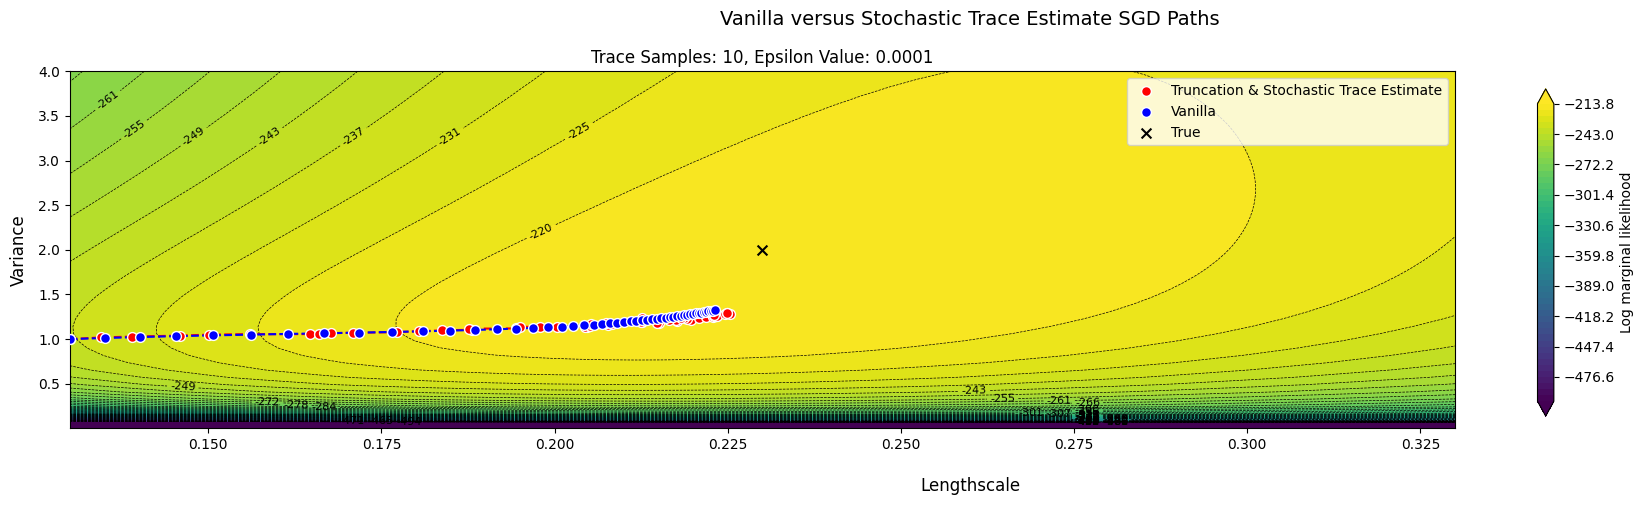

In [16]:

# Clip values below -100 to prevent extreme low outliers
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())
log_marginal_clipped = log_marginals_grid

# Set up filled contour levels (detailed)
# set fill and line levels based on the data

fill_levels = np.linspace(-500, log_marginals_grid.max(), 50)
# Use fewer contour levels for the line overlay
line_levels = np.linspace(-500, log_marginals_grid.max(), 50)

# Determine subplot grid dimensions for 2 rows
n_plots = len(results)
n_rows = 1
n_cols = int(np.ceil(n_plots / n_rows))
tracked_lengthscales_vanilla_arr = np.array(tracked_lengthscales_vanilla)
tracked_variances_vanilla_arr = np.array(tracked_variances_vanilla)
# Create a grid of subplots with 2 rows and the required number of columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5), sharex=True, sharey=True)
# Ensure axes is always a 1D numpy array for consistent iteration
if isinstance(axes, np.ndarray):
    axes = axes.ravel()
else:
    axes = np.array([axes])
# Plot each result in its respective subplot
for i, ax in enumerate(axes):
    # if i < n_plots:  # Only plot if there's data for this subplot
    #     tracked_lengthscales_truncated_arr = tracked_lengthscales_truncated
    #     tracked_variances_truncated_arr = tracked_variances_truncated
    if i < n_plots:  # Only plot if there's data for this subplot
        # Plot filled contours
        cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T,
                         levels=fill_levels, cmap='viridis', extend='both')
        # Overlay a reduced number of contour lines for clarity
        cs = ax.contour(lengthscales, variances, log_marginal_clipped.T,
                        levels=line_levels, colors='k', linewidths=0.5)
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')

        # Overlay tracked hyperparameter points for the current result
        # Ensure tracked_lengthscales and tracked_variances are properly populated
        tracked_lengthscales_arr = np.array(results[i].get('tracked_lengthscales', []))
        tracked_variances_arr = np.array(results[i].get('tracked_variances', []))
        ax.scatter(tracked_lengthscales_arr, tracked_variances_arr,
                   color='red', edgecolors='w', s=50, label='Truncation & Stochastic Trace Estimate', zorder=10)
        ax.plot(tracked_lengthscales_arr, tracked_variances_arr,
                color='red', linestyle='--', zorder=9)
        # overlay vanilla tracked points

        ax.scatter(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                   color='blue', edgecolors='w', s=50, label='Vanilla', zorder=10)
        ax.plot(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                color='blue', linestyle='--', zorder=9)
        #overlay truncated tracked points

        # ax.scatter(tracked_lengthscales_truncated_arr, tracked_variances_truncated_arr,
        #            color='green', edgecolors='w', s=50, label='Tracked points (Truncated)', zorder=10)
        # Set title for each subplot
        ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)

        ax.set_title(f"Trace Samples: {results[i]['trace_samples']}, Epsilon Value: {results[i]['epsilon']}", fontsize=12)
        
        # add legend
        ax.legend(fontsize=10)

    else:
        # If no data is available for this subplot, turn the axis off.
        ax.axis('off')

# Add a colorbar to the figure, placed outside the subplots
cbar = fig.colorbar(cf, ax=axes.tolist(), label='Log marginal likelihood', shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)
# Label the shared axes
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)
plt.suptitle('Vanilla versus Stochastic Trace Estimate SGD Paths', fontsize=14)
plt.tight_layout(rect=[.01, 0, 0.75, 1])  # Adjust layout to make space for the colorbar
# plt.savefig('/Users/colecitrenbaum/Documents/GPs/Figures/vanilla_vs_sgd.png', dpi=300)
plt.show()

# save a high res version of the plot


# Agrees with Gpytorch as well 

In [17]:
# import gpytorch
# sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance

# # ─── 1) Assume you already have these:
# #    train_x, train_y: your data tensors
# #    init_kernel:      an object with .lengthscale and .variance
# #    sigmasq:          a tensor (or scalar tensor) for your noise variance
# # ─────────────────────────────────────────────────────────────────────────

# # ─── 2) Define your Exact GP
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, x, y, likelihood):
#         super().__init__(x, y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.RBFKernel()
#         )
#     def forward(self, x):
#         return gpytorch.distributions.MultivariateNormal(
#             self.mean_module(x),
#             self.covar_module(x)
#         )

# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model      = ExactGPModel(x, y, likelihood)

# # Initialize to match your “init_kernel”
# # Ensure init_kernel.lengthscale and variance are torch tensors
# # --- Fix: Ensure lengthscale and variance are at least 1D tensors ---
# def ensure_1d_tensor(val, dtype, device):
#     t = torch.as_tensor(val, dtype=dtype, device=device)
#     if t.ndim == 0:
#         t = t.unsqueeze(0)
#     return t

# lengthscale_tensor = ensure_1d_tensor(
#     init_kernel.lengthscale,
#     dtype=model.covar_module.base_kernel.raw_lengthscale.dtype,
#     device=model.covar_module.base_kernel.raw_lengthscale.device
# )
# variance_tensor = ensure_1d_tensor(
#     init_kernel.variance,
#     dtype=model.covar_module.raw_outputscale.dtype,
#     device=model.covar_module.raw_outputscale.device
# )
# sigmasq_tensor = torch.as_tensor(sigmasq, dtype=likelihood.raw_noise.dtype, device=likelihood.raw_noise.device)

# model.covar_module.base_kernel.raw_lengthscale.data = \
#     model.covar_module.base_kernel.raw_lengthscale_constraint.inverse_transform(
#         lengthscale_tensor
#     )
# model.covar_module.outputscale = variance_tensor
# likelihood.noise = sigmasq_tensor

# model.train()
# likelihood.train()

# # ─── 3) Set up optimizer + MLL
# optimizer = torch.optim.Adam(
#     list(model.parameters()) + list(likelihood.parameters()), lr=1e-3
# )
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# # ─── 4) One gradient step, but *rescale* to get the full‐N data gradient
# optimizer.zero_grad()
# output   = model(x)
# loss_avg = -mll(output, y)               # this is (1/n)×NLL
# n_data   = y.numel()
# loss_full= loss_avg * n_data                   # now it’s the true NLL
# loss_full.backward()

# # ─── 5) Extract raw gradient ∂Loss/∂ρ
# raw_param = model.covar_module.base_kernel.raw_lengthscale
# raw_grad  = raw_param.grad                     # ∂NLL/∂ρ

# # ─── 6) Compute dℓ/dρ via the constraint’s transform
# constraint  = model.covar_module.base_kernel.raw_lengthscale_constraint
# raw_for_jac = raw_param.detach().clone().requires_grad_(True)
# ℓ_for_jac    = constraint.transform(raw_for_jac) 
# (dldρ,)      = torch.autograd.grad(ℓ_for_jac, raw_for_jac)

# # ─── 7) Chain rule: ∂NLL/∂ℓ = (∂NLL/∂ρ) / (dℓ/dρ)
# dLoss_dℓ = raw_grad / dldρ

# # If the lengthscale is a 1-element tensor, print the scalar value
# if dLoss_dℓ.numel() == 1:
#     print(f"Raw grad     ∂NLL/∂ρ   = {raw_grad.item(): .6f}")
#     print(f"dℓ/dρ               = {dldρ.item(): .6f}")
#     print(f"True grad ∂NLL/∂ℓ    = {dLoss_dℓ.item(): .6f}")
# else:
#     print(f"Raw grad     ∂NLL/∂ρ   = {raw_grad}")
#     print(f"dℓ/dρ               = {dldρ}")
#     print(f"True grad ∂NLL/∂ℓ    = {dLoss_dℓ}")


$$\alpha = (K+\sigma^2 I)^{-1}y$$

$$\frac{\partial (K + \sigma^2 I)}{\partial \theta} = FD'F^* + \frac{\partial (\sigma^2 I)}{\partial \theta}$$
where 
$$D'_{jj} = h^d\frac{\partial }{\partial \theta} \hat{k}_\theta(\xi_j)